## Electric Energy Load Demand Forecasting for Rural Area

In [1]:
import io
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.svm import SVR

In [3]:
from scipy import stats

In [5]:
# Run this cell only in the Google Colab
# Tensorflow version 2.x
#%tensorflow_version 2.x

In [6]:
import tensorflow as tf
from tensorflow import keras

In [7]:
# Run this cell ONLY in the Google Colab
#! pip install keras-tuner

In [8]:
# Run this cell ONLY in the Google Colab
import kerastuner as kt

In [9]:
# Test for GPU presence
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found!')
else:
    print('Found GPU at: {}'.format(device_name))

GPU device not found!


In [10]:
# Run this cell only in the Google Colab
# Display GPU information
!nvidia-smi -q

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


In [11]:
try:
    import seaborn as sns
    # Seaborn style (figure aesthetics only)
    sns.set(context='paper', style='whitegrid', font_scale=1.2)
    sns.set_style('ticks', {'xtick.direction':'in', 'ytick.direction':'in'})
except ImportError:
    print('Seaborn not installed. Going without it.')

### Load and Weather time-series data

In [12]:
# function to read load data 
def data_reader(file_name):
    data = pd.read_excel(file_name, parse_dates=True, 
                            index_col='Time', usecols=range(2))
    return data


# function to read weather data
def weather_reader(file_name):
    weather = pd.read_excel(file_name, parse_dates=True, 
                            index_col='Time measured')
    return weather


def data_reader_colab(filename, colab_files):
    """ Read data inside the Google Colab

    Arguments
    ---------
    file_name: string
        name of the excel file which is being read
    colab_files: dict
        dictionary returned by the google.colab with keys 
        as file names and values as binary files

    Returns
    -------
    data: pd.DataFrame
        pandas dataframe holding time-series load data
    """
    data = pd.read_excel(io.BytesIO(colab_files[filename]), 
                         parse_dates=True, index_col='Time', 
                         usecols=range(2))
    return data


def weather_reader_colab(filename, colab_files):
    """ Read data inside the Google Colab

    Arguments
    ---------
    file_name: string
        name of the excel file which is being read
    colab_files: dict
        dictionary returned by the google.colab with keys 
        as file names and values as binary files

    Returns
    -------
    data: pd.DataFrame
        pandas dataframe holding time-series weather data
    """
    data = pd.read_excel(io.BytesIO(colab_files[filename]), 
                         parse_dates=True, 
                         index_col='Time measured')
    return data


# function for concatenating load data and weather data for training
def concat_data(file_name_load, file_name_weather):
    train_data = pd.concat([file_name_load, file_name_weather], axis=1)
    return train_data

In [13]:
# Load weather & load time-series data
load_file_name = 'Index_Bjønntjønn_2014_2018.xlsx'
weather_file_name = 'bo_temp_2014_2018.xlsx'

# If the files have already been uploaded there is no need to do it again.
file_names = [load_file_name, weather_file_name]
files_present = 0
for file_name in file_names:
    try:
        f = open(file_name, 'rb')
        print('Found file with a file name: {}'.format(file_name))
        files_present += 1
    except (IOError, FileNotFoundError):
        print('There is NO file with a file name: {}'.format(file_name))
    else:
        f.close()
# Check if all files are already present
if files_present == 2:
    # Don't need to upload files (they already exist!).
    UPLOAD = False
    print('All files are already uploaded.')
else:
    # Need to upload files (they don't exist!).
    UPLOAD = True
    print('Need to upload files.')

Found file with a file name: Index_Bjønntjønn_2014_2018.xlsx
Found file with a file name: bo_temp_2014_2018.xlsx
All files are already uploaded.


In [14]:
# Google Colab: upload files if there is none already present.
try:
    from google.colab import files
    # We are inside the Google Colab
    COLAB = True
    # If the files have already been uploaded there is no need to do it again.
    if UPLOAD == True:
        # Google Colab file upload (upload files only once)
        uploaded_files = files.upload()
except ImportError:
    # We are NOT inside the Google Colab
    COLAB = False

In [15]:
if COLAB and UPLOAD:
    # Reading files just uploaded inside a Google Colab
    load_data = data_reader_colab(load_file_name, uploaded_files)
    weather_data = weather_reader_colab(weather_file_name, uploaded_files)
else:
    # Reading existing files from a local disk or a virtual storage
    load_data = data_reader(load_file_name)
    weather_data = weather_reader(weather_file_name)

# Interpolate weather data time-series
weather_data = weather_data.interpolate()
# Concatenate
dataframe = concat_data(load_data, weather_data)
# Rename columns for easier interpreting:
dataframe = dataframe.rename(columns={"Total":"Load",
                                      "Middeltemperatur i 2m høyde (TM)": "Temperature"})

In [16]:
dataframe.head()

,Load,Temperature
2014-01-01 01:00:00,227.0,2.9
2014-01-01 02:00:00,216.0,3.0
2014-01-01 03:00:00,197.0,3.0
2014-01-01 04:00:00,198.0,3.1
2014-01-01 05:00:00,198.0,3.5


In [17]:
def show_plots(data, time_start, time_end=None):
    # Ploting time-series data with different time ranges
    fig, ax = plt.subplots(figsize=(7,4.5))
    ax2 = ax.twinx()
    if time_end is None:
        data['Load'].loc[time_start].plot(
            c='seagreen', label='Load', ax=ax)
        data['Temperature'].loc[time_start].plot(
            c='darkorange', label='Temperature', ax=ax2)
    else:
        data['Load'].loc[time_start:time_end].plot(
            c='seagreen', label='Load', ax=ax)
        data['Temperature'].loc[time_start:time_end].plot(
            c='darkorange', label='Temperature', ax=ax2)
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax.set_ylabel('Load', fontsize=12, fontweight='bold', 
                  color='seagreen')
    ax2.set_ylabel('Temperature', fontsize=12, 
                   fontweight='bold', color='darkorange')
    fig.tight_layout()
    plt.show()
    return

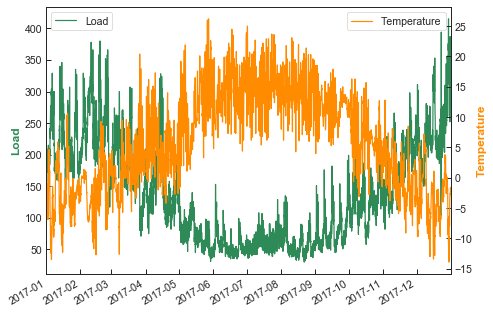

In [18]:
# Time-series for 2018
show_plots(dataframe, '2017')

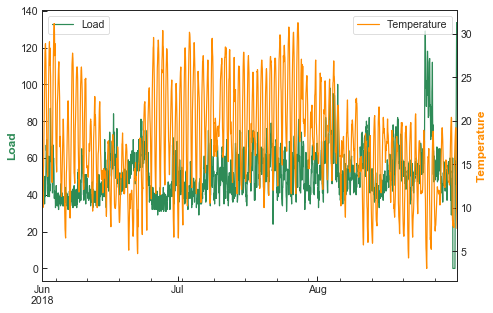

In [19]:
# Time-series for June to August 2018
show_plots(dataframe, '2018-06', '2018-08')

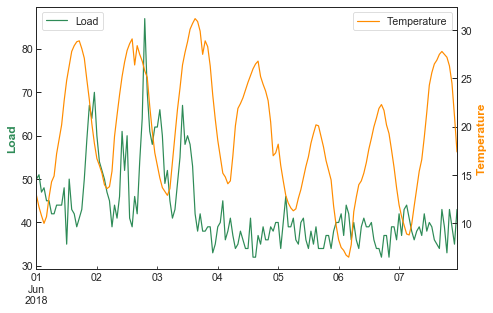

In [20]:
show_plots(dataframe, '2018-06-01', '2018-06-07')

### Multivariate multi-step load forecasting with feed-forward neural networks

In [21]:
# Hard-coding holiday dates
holiday_dates = {
    # 2014 year
    '2014-Jan-1st': ('2014-01-01', None),  # single day
    '2014-Easter': ('2014-04-14', '2014-04-21'),  # date range
    '2014-May-1st': ('2014-05-01', None),
    '2014-Pentecost': ('2014-06-07', '2014-06-10'),
    '2014-Xmas': ('2014-12-21', '2014-12-31'),
    # 2015 year
    '2015-Jan-1st': ('2015-01-01', None),
    '2015-Easter': ('2015-03-30', '2015-04-06'),
    '2015-May-1st': ('2015-05-01', None),  # Friday
    '2015-Ascension': ('2015-05-14', None),
    '2015-Pentecost': ('2014-05-24', '2014-05-25'),
    '2015-Xmas': ('2015-12-23', '2015-12-31'),
    # 2016 year
    '2016-Jan-1st': ('2016-01-01', None),
    '2016-Easter': ('2016-03-21', '2016-03-28'),
    '2016-May-1st': ('2015-05-01', None),  # Sunday
    '2016-Ascension': ('2016-05-05', None),
    '2016-Pentecost': ('2016-05-16', '2016-05-17'),
    '2016-Xmas': ('2016-12-26', '2016-12-31'),
    # 2017 year
    '2017-Jan-1st': ('2017-01-01', None),
    '2017-Easter': ('2017-04-10', '2017-04-17'),
    '2017-May-1st': ('2017-05-01', None),  # Monday
    '2017-May-17th': ('2017-05-17', None),  # Wednesday
    '2017-Ascension': ('2017-05-25', None),
    '2017-Pentecost': ('2017-06-05', None),
    '2017-Xmas': ('2017-12-25', '2017-12-31'),
    # 2018 year
    '2018-Jan-1st': ('2018-01-01', None),
    '2018-Easter': ('2018-03-26', '2018-04-02'),
    '2018-May-1st': ('2018-05-01', None),  # Tuesday
    '2018-Ascension': ('2017-05-10', None),  # Thursday
    '2018-May-17th': ('2017-05-17', None),
    '2018-Pentecost': ('2018-05-21', None),
    '2018-Xmas': ('2018-12-24', '2018-12-31')
}

In [22]:
def engineer_features(dataframe, holiday_dates, columns, time_lags=24, 
                      steps_ahead=1, drop_nan_rows=True):
    """Engineering features
    
    Load data features column names with underscore (i.e. Load_1h, Load_2h, etc.) 
    represent time-lags (t-1, t-2, ...), while those with plus sign (i.e. Load+1h, 
    Load+2h, etc.) represent future time-steps (t+1, t+2, ...); column with name
    Load+0h represents current load at time instant t. 
    
    Parameters
    ----------
    dataframe: pd.DataFrame
        original dataframe with time-series data
    holiday_dates: dictionary
        dictionary with tuples specifying local holiday dates or date-ranges
    columns: list
        list of column names from the dataframe which are used for the 
        features engineering (i.e. time-lags)
    time_lags: int
        number of time lags for use with feature engineering
    steps_ahead: int
        number of steps ahead for multi-step forecasting (steps_ahead=1
        means single-step ahead forecasting)
    drop_nan_rows: bool
        True/False indicator to drop rows with NaN values

    Returns
    -------
    dataframe: pd.DataFrame
        dataframe augmented with additional features
    """
    
    # Make a copy of the original dataframe
    data = dataframe[columns].copy()
            
    # Features engineering
    for col in data.columns:
        for i in range(1, time_lags+1):
            # Shift data by lag of 1 to time_lags (default: 24) hours
            data[col+'_{:d}h'.format(i)] = data[col].shift(periods=i)  # time-lag
        data[col+'_diff'] = data[col].diff()  # first-difference
        data[col+'_week'] = data[col].shift(periods=24*7)  # previous week
    
    # Hour-of-day indicators with cyclical transform
    dayhour_ind = data.index.hour
    data['hr_sin'] = np.sin(dayhour_ind*(2.*np.pi/24))
    data['hr_cos'] = np.cos(dayhour_ind*(2.*np.pi/24))
    
    # Day-of-week indicators with cyclical transform
    weekday_ind = data.index.weekday
    data['week_sin'] = np.sin(weekday_ind*(2.*np.pi/7))
    data['week_cos'] = np.cos(weekday_ind*(2.*np.pi/7))

    # Weekend as a binary indicator
    data['weekend'] = np.asarray([0 if ind <= 4 else 1 for ind in weekday_ind])

    # Month indicators with cyclical transform
    month_ind = data.index.month
    data['mnth_sin'] = np.sin((month_ind-1)*(2.*np.pi/12))
    data['mnth_cos'] = np.cos((month_ind-1)*(2.*np.pi/12))
    
    # Holidays as a binary indicator
    data['holidays'] = 0
    for holiday, date in holiday_dates.items():
        if date[1] is None:
            # Single day
            data.loc[date[0], 'holidays'] = 1
        else:
            # Date range
            data.loc[date[0]:date[1], 'holidays'] = 1
    
    # Forecast horizont
    if steps_ahead == 1:
        # Single-step forecasting
        data['Load+0h'] = data['Load'].values
    else:
        # Multi-step forecasting
        for i in range(steps_ahead):
            data['Load'+'+{:d}h'.format(i)] = data['Load'].shift(-i)
    del data['Load']
    
    if drop_nan_rows:
        # Drop rows with NaN values
        data.dropna(inplace=True)
        
    return data

In [23]:
def train_test_split(dataframe, start_date, window_days=100, train_percent=80.,
                     return_arrays=False):
    """Train and test data set split
    
    Parameters
    ----------
    dataframe: pd.DataFrame
        dataframe augmented with additional features
    start_date: string
        starting date of the time-series 
    window_days: int
        size of the data window in days
    train_percent: float
        percentage of the data window size to use for creating the 
        training data set (the rest is used for testing)
    return_arrays: bool
        True/False indicator which defines the type of output; if 
        True function returns numpy arrays; if False it returns
        pandas dataframes
    
    Returns
    -------
    X_train: pd.DataFrame or np.array
        training data 2D array of input features
    y_train: pd.DataFrame or np.array
        training data array of target values
    X_test: pd.DataFrame or np.array
        testing/validation data 2D array of input features
    y_test: pd.DataFrame or np.array
        testing/validation data array of target values
    """
    data = dataframe.copy()
    if window_days*24 > data.values.shape[0]:
        raise ValueError('Variable window_days has too large value: {}*24h = {} > {}, \
            which is more than there is data!'.format(window_days, window_days*24, 
                                                      data.values.shape[0]))
    
    # Split dataframe into X, y
    columns = data.columns.values
    outputs = [col_name for col_name in columns if 'Load+' in col_name]
    inputs = [col_name for col_name in columns if col_name not in outputs]
    # inputs (features)
    X = data[inputs]
    # outputs
    y = data[outputs]
    
    # Training period
    train_percent = train_percent/100.
    st = pd.to_datetime(start_date)  # start date
    et = st + dt.timedelta(days=int(train_percent*window_days))  # end date
    X_train = X.loc[st:et]
    y_train = y.loc[st:et]
    
    # Testing / Validation period
    sv = et 
    ev = sv + dt.timedelta(days=int((1-train_percent)*window_days)+1)
    X_test = X.loc[sv:ev]
    y_test = y.loc[sv:ev]
        
    if return_arrays:
        # Returning numpy arrays
        return X_train.values, y_train.values, X_test.values, y_test.values
    else:
        # Returning pandas dataframes
        return X_train, y_train, X_test, y_test

In [24]:
# Day-ahead short-term load forecasting with time-series data
STEPS_AHEAD = 24           # hours-ahead for prediction
START_DATE = '2014-01-09'  # starting date of the time-series
WINDOW_SIZE_DAYS = 400     # window size in days for training and validation

In [25]:
# day-ahead (i.e. 24-hours ahead) forecasting
data_features = engineer_features(dataframe, holiday_dates, 
                                  columns=['Load', 'Temperature'], 
                                  steps_ahead=STEPS_AHEAD)

In [26]:
# Split dataset into training and test/validation sets
X_train, y_train, X_test, y_test = train_test_split(
    data_features, 
    start_date=START_DATE, 
    window_days=WINDOW_SIZE_DAYS)

In [27]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7681, 61) (7681, 24)
(1921, 61) (1921, 24)


In [28]:
# Scale and transform input data
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

## Support Vector Machine multi-step regressor

In [33]:
# Single-step ahead time-series regression
# Randomized grid search with cross-validation
parameters = {'C':stats.uniform(loc=1e-4, scale=1e5),
              'epsilon':stats.uniform(loc=1., scale=1e4),
              'gamma':['auto', 'scale']}
svr = RandomizedSearchCV(estimator=SVR(kernel='rbf'), 
                         param_distributions=parameters, n_iter=5000, 
                         cv=TimeSeriesSplit(n_splits=3), 
                         scoring='neg_mean_squared_error', 
                         refit=True, n_jobs=-1, verbose=1)
svr.fit(X_train, y_train.values[:,0])  # do not use scaled data
print(svr.best_params_)

Fitting 3 folds for each of 5000 candidates, totalling 15000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 671 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 2664 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 4648 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 7427 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 9560 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 12172 tasks      | elapsed:   50.5s
[Parallel(n_jobs=-1)]: Done 15000 out of 15000 | elapsed:  1.1min finished


{'C': 18505.98795483825, 'epsilon': 4.591221484777751, 'gamma': 'scale'}


In [34]:
# Using best hyper-parameters from the single-step ahead regression
multi_svr = MultiOutputRegressor(estimator=SVR(kernel='rbf', **svr.best_params_), n_jobs=-1)
multi_svr.fit(X_train, y_train)

MultiOutputRegressor(estimator=SVR(C=18505.98795483825, cache_size=200,
                                   coef0=0.0, degree=3,
                                   epsilon=4.591221484777751, gamma='scale',
                                   kernel='rbf', max_iter=-1, shrinking=True,
                                   tol=0.001, verbose=False),
                     n_jobs=-1)

In [ ]:
# A multi-step model that arranges regressions into a chain. Each model makes a prediction
# in the order specified by the chain using all of the available features provided to the
# model plus the predictions of models that are earlier in the chain. Base model is SVM!
chain_svr = RegressorChain(base_estimator=SVR(kernel='rbf', **svr.best_params_))
chain_svr.fit(X_train.values, y_train.values)

## DecisionTree multi-step regressor

In [ ]:
# DecisionTreeRegressor supports multi-step output out-of-the-box!
# Grid search with cross-validation
parameters = [{'criterion':['mse', 'mae'],
              'max_depth':[1, 5, None],
              'max_features':['auto', 'log2', 0.5],
              'max_leaf_nodes':[1, 2, None]}]
tree = GridSearchCV(estimator=DecisionTreeRegressor(), 
                          param_grid=parameters,
                          cv=TimeSeriesSplit(n_splits=3), 
                          scoring='neg_mean_squared_error', 
                          refit=True, n_jobs=-1, verbose=1)
tree.fit(X_train, y_train)  # do not use scaled data
print(tree.best_params_)

## Feed-forward deep ANN using functional `tf.keras` API

In [ ]:
BATCH_SIZE = 256  # batch size for training
EPOCHS = 300      # epochs for training
WAIT = 20         # patience for early stopping
LR = 1e-3         # initial learning rate

In [ ]:
# Feed-forward and fixed funnel-shaped deep ANN
# tf.keras functional API
input_layer = keras.layers.Input(shape=X_train_sc.shape[1:])
x = keras.layers.Dense(units=1024, activation='relu')(input_layer)
x = keras.layers.Dropout(0.1)(x)  # regularization
x = keras.layers.Dense(units=512, activation='relu')(x)
x = keras.layers.Dense(units=512, activation='relu')(x)
x = keras.layers.Dropout(0.1)(x)  # regularization
x = keras.layers.Dense(units=256, activation='relu')(x)
output_layer = keras.layers.Dense(STEPS_AHEAD)(x)
model = keras.models.Model(inputs=input_layer, outputs=output_layer)
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    LR, decay_steps=EPOCHS, decay_rate=0.96, staircase=False)
adam = keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(loss='mae', optimizer=adam, metrics=['mae', 'mape'])
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.1, patience=WAIT, 
    verbose=1, restore_best_weights=True)
history = model.fit(X_train_sc, y_train.values, 
                    batch_size=BATCH_SIZE, epochs=EPOCHS, 
                    validation_split=0.2, shuffle=True, 
                    callbacks=[early_stop], verbose=1,
                    use_multiprocessing=True)

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
print('MAE val_loss at final epoch is {:.2f}, while min. val_loss is {:.2f}.'
      .format(val_loss[-1], min(val_loss)))
plt.plot(loss, label='train')
plt.plot(val_loss, label='validation')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('MAE loss value')
plt.show()

#### Using `keras-tuner` for fine-tuning ANN architecture and hyper-parameters

In [ ]:
def build_keras_model(hp):
    # Input layer
    input_layer = keras.layers.Input(shape=X_train_sc.shape[1:])
    x = input_layer
    # Try different number of hidden layers
    for i in range(hp.Int('num_layers', 2, 6)):
        # Dense layer type
        x = keras.layers.Dense(units=hp.Int('units_{}'.format(i), min_value=256, 
                                            max_value=1024, step=256), 
                               activation=hp.Choice('act_{}'.format(i), 
                                                    values=['relu', 'tanh']))(x)
        # Regularization layer type
        x = keras.layers.Dropout(hp.Float('drop_{}'.format(i), 0., 0.5, step=0.1, 
                                          default=0.1))(x)
    # Output layer
    output_layer = keras.layers.Dense(STEPS_AHEAD)(x)
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    # Optimize learning rate as well
    adam = keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log'))
    # Compile model
    model.compile(loss='mae', optimizer=adam, metrics=['mae'])
    return model

In [ ]:
# Run this cell ONLY in the Google Colab
# Define keras tuner
tuner = kt.Hyperband(build_keras_model, objective='val_loss', max_epochs=EPOCHS)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1, 
                                           patience=WAIT, verbose=0,
                                           restore_best_weights=True)
tuner.search(X_train_sc, y_train.values, epochs=EPOCHS,
             validation_data=(X_test_sc, y_test.values),
             callbacks=[early_stop], verbose=1)

In [ ]:
# Run this cell ONLY in the Google Colab
# Summary of keras-tuner search results
tuner.results_summary()

In [ ]:
# Run this cell ONLY in the Google Colab
# Re-create best model found by the keras-tuner
model = tuner.get_best_models(num_models=1)[0]
# View the summary of the best model
model.summary()

In [ ]:
# Save a trained model (architecture and weights) on disk.
# This model can be loaded and used without re-training:
# model = keras.models.load_model('model-dense-dnn.tf')
# for making predictions, or it can be restored and tra-
# ining of the model can be continued from where it was.
model.save('model-dense-dnn.tf')

In [ ]:
def prepare_test_data(dataframe, start_date, window_days, test_size=1):
    """ Prepare test data
    
    Arguments
    ---------
    dataframe: pd.DataFrame
        original dataframe with features
    start_date: string
        starting date for the time-series previously used
        in creating the train and test/validation data sets
    window_days: int
        size of the data window in days previously used
        in creating the train and test/validation data sets
    test_size: int
        number of time-steps (hours) for walk-forward testing
        
    Returns
    -------
    X_new: np.array
        walk-forward testing data set as numpy array
    """
    data = dataframe.copy()
    date_test_start = pd.to_datetime(start_date) + dt.timedelta(days=window_days)
    date_test_end = date_test_start + dt.timedelta(hours=test_size)
    
    columns = data.columns.values
    outputs = [col_name for col_name in columns if 'Load+' in col_name]
    inputs = [col_name for col_name in columns if col_name not in outputs]
    
    if test_size == 1:
        # Array with a single value needs to be reshaped accordingly
        X_new = data[inputs].loc[date_test_start].values.reshape(1,-1)
    else:
        X_new = data[inputs].loc[date_test_start:date_test_end].values[:-1]

    return X_new

In [ ]:
TEST_SIZE = 12  # walk-forward for 12 hours
X_new = prepare_test_data(data_features, START_DATE, WINDOW_SIZE_DAYS, TEST_SIZE)

In [ ]:
# Transform test values using scaler
X_new_sc = scaler.transform(X_new)

In [ ]:
# Predict on new values 
# ---------------------
# Feed-forward ANN
y_pred_ann = model.predict(X_new_sc)
# Support Vector Machine (Regressor)
y_pred_svr_reg = multi_svr.predict(X_new)
# Support Vector Machine (Chained)
y_pred_svr_chn = chain_svr.predict(X_new)
# DecisionTrees
y_pred_tree = tree.predict(X_new)

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Mean absolute percentage error
    
    Parameters
    ----------
    y_true: np.array
        array holding true values
    y_pred: np.array
        array holding predictions
    
    Returns
    -------
    mape: float
        mean absolute percentage error value
    """
    if len(y_true.shape) > 1 or len(y_pred.shape) > 1:
        raise TypeError('Arrays need to be one-dimensional.')
        
    mape = np.mean(np.abs((y_true - y_pred)/y_true))*100.
    
    return mape

In [ ]:
# Plotting multi-step ahead predictions using the walk-forward method
if TEST_SIZE == 1: 
    raise ValueError('TEST_SIZE: Need a multi-step ahead predictions!')
    
date_start = pd.to_datetime(START_DATE) + dt.timedelta(days=WINDOW_SIZE_DAYS)
for i in range(TEST_SIZE):
    date_end = date_start + dt.timedelta(hours=23)
    y_true = data_features['Load+0h'].loc[date_start:date_end]
    y_values = pd.DataFrame(y_true)
    y_values = y_values.rename(columns={'Load+0h':'Actual'})
    y_values['ANN'] = y_pred_ann[i,:]
    y_values['SVR-Reg'] = y_pred_svr_reg[i,:]
    y_values['SVR-Chn'] = y_pred_svr_chn[i,:]
    y_values['Tree'] = y_pred_tree[i,:]
    
    # Ensemble predictions using weighted-average
    models = ['ANN', 'SVR-Reg', 'SVR-Chn', 'Tree']
    y_values['Ensemble'] = np.average(y_values[models].values, 
                                      axis=1,  # by columns
                                      weights=[0.3, 0.25, 0.4, 0.05])  # with weights
    
    # Absolute percentage errors
    y_values['APE-ANN'] = np.abs((y_values['Actual'] - y_values['ANN'])/y_values['Actual'])*100.
    y_values['APE-SVR-Reg'] = np.abs((y_values['Actual'] - y_values['SVR-Reg'])/y_values['Actual'])*100.
    y_values['APE-SVR-Chn'] = np.abs((y_values['Actual'] - y_values['SVR-Chn'])/y_values['Actual'])*100.
    y_values['APE-Tree'] = np.abs((y_values['Actual'] - y_values['Tree'])/y_values['Actual'])*100.
    y_values['APE-Ensemble'] = np.abs((y_values['Actual'] - y_values['Ensemble'])/y_values['Actual'])*100.

    # Mean absolute percentage errors
    for m in models:
        mape = mean_absolute_percentage_error(y_values['Actual'].values, y_values[m].values)
        print('MAPE-{} = {:.2f} (%)'.format(m, mape))
    # Ensemble MAPE (weighted average of base models)
    mape = mean_absolute_percentage_error(y_values['Actual'].values, 
                                          y_values['Ensemble'].values)
    print('MAPE-Ensemble = {:.2f} (%)'.format(mape))
    
    # Plot figures
    y_values[['Actual', 'ANN', 'SVR-Reg', 'SVR-Chn', 'Tree', 'Ensemble']].plot(figsize=(5.5,4))
    plt.ylabel('Load')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()
    date_start = date_start + dt.timedelta(hours=1)

# Multivariate multi-step load forecasting with convolutional neural networks

In [ ]:
def samples_timesteps_features(dataframe, columns, start_date, timesteps=72, 
                               steps_ahead=24, window_days=100, train_percent=80.):
    """
    Restructure original dataframe with columns time-series data into a 3D array
    of shape: [samples, timesteps, features] for the use with convolutional layers.
    First dimension of the output array is the number of samples, which is determined
    automatically from the size of the window. Second dimension is determined by the 
    number of timesteps and defines how many time steps from the past will be used in
    the internal processing of the convolutional layer. The third dimension is the
    number of features in the original dataset, which is defined by the number of 
    columns that are used from the original dataframe.
    
    Parameters
    ----------
    dataframe: pd.DataFrame
        dataframe with the original time-series data
    columns: list
        list of column names from the dataframe which are used
    start_date: string
        starting date of the time-series 
    timesteps: int
        number of time steps from the past for creating output arrays
    steps_ahead: int
        number of time steps into the future for making predictions
    window_days: int
        size of the data window in days
    train_percent: float
        percentage of the data window size to use for creating the 
        training data set (the rest is used for testing)
    
    Returns
    -------
    mean_std_values: dictionary
        dictionary with tuples holding mean value and standard
        deviation for each of the columns in the dataframe
    X_train: np.array
        training data 2D array of features
    y_train: np.array
        training data array of targets
    X_test: np.array
        testing/validation data 2D array of features
    y_test: np.array
        testing/validation data array of targets 
    """
    
    def overlap_windows(dataset, timesteps, steps_ahead):
        """ Create overlaping window of time-series data
        
        Parameters
        ----------
        dataset: pd.DataFrame
            time-series pandas dataset
        timesteps: int
            number of time steps from the past for creating output arrays
        steps_ahead: int
            number of time steps into the future for making predictions
        
        Returns
        -------
        X, y: np.array
            input and output 3-d arrays of overlaping time windows
        """
        X = []; y = []
        
        start = 0
        for i in range(len(dataset)):
            # Define the end of the input sequence
            in_end = start + timesteps
            out_end = in_end + steps_ahead
            # Ensure that there is enough data
            if out_end <= len(dataset):
                X.append(dataset[start:in_end, :])
                # First column holds load values
                y.append(dataset[in_end:out_end, 0])
            # Move along one time step
            start += 1
            
        # Convert list to np.array
        X = np.asarray(X)
        y = np.asarray(y)
        
        return X, y


    data = dataframe.copy()
    
    if window_days*24 > data.values.shape[0]:
        raise ValueError('Variable window_days has too large value: {}*24h = {} > {}, \
            which is more than there is data!'.format(window_days, window_days*24, 
                                                      data.values.shape[0]))
    
    # Training period
    # ---------------
    train_percent = train_percent/100.
    st = pd.to_datetime(start_date)  # start date
    et = st + dt.timedelta(days=int(train_percent*window_days))  # end date
    train = data.loc[st:et].values
    
    # Standardize and transform training data set
    mean_std_values = {}
    for i, column in enumerate(columns):
        # Calculate mean and standard deviation only
        # from the training data set values
        mu = train[:,i].mean()  # axis=0
        sd = train[:,i].std()
        mean_std_values[column] = (mu, sd)
        # Standardize training data
        train[:,i] = (train[:,i] - mu)/sd
    
    # Create overlapping windows with training data
    X_train, y_train = overlap_windows(train, timesteps, steps_ahead)
    
    # Testing / Validation period
    # ---------------------------
    sv = et 
    ev = sv + dt.timedelta(days=int((1-train_percent)*window_days)+1)
    test = data.loc[sv:ev].values
    
    # Transform testing/validation data set
    for i, column in enumerate(columns):
        # Use mean and standard deviation from the
        # training data set
        mu = mean_std_values[column][0]
        sd = mean_std_values[column][1]
        # Standardize test data
        test[:,i] = (test[:,i] - mu)/sd
    
    # Create overlaping windows with test data
    X_test, y_test = overlap_windows(test, timesteps, steps_ahead)
    
    return mean_std_values, X_train, y_train, X_test, y_test

In [ ]:
# Day-ahead (i.e. 24-hours ahead) short-term load prediction with time-series data
START_DATE = '2014-01-09'  # starting date of the time-series data
HISTORY_SIZE = 7*24        # window size in hours for the past history values (7*24=168)
STEPS_AHEAD = 24           # hours-ahead for prediction
WINDOW_SIZE_DAYS = 300     # window size in days for training and validation

In [ ]:
# Training, Validation and Testing data sets
mean_std_values, X_train, y_train, X_test, y_test = samples_timesteps_features(
    dataframe, ['Load', 'Temperature'], 
    start_date=START_DATE, 
    timesteps=HISTORY_SIZE, 
    steps_ahead=STEPS_AHEAD,
    window_days=WINDOW_SIZE_DAYS)

In [ ]:
print('Training data shape:')
print(X_train.shape, y_train.shape)
print('Validation/Testing data shape:')
print(X_test.shape, y_test.shape)

In [ ]:
BATCH_SIZE = 256       # batch size
EPOCHS = 20            # number of epochs for training
STEPS_PER_EPOCH = 100  # steps per epoch for training
VAL_STEPS = 50         # validation steps during training
WAIT = 10              # patience for early stopping
LR = 1e-3              # learning rate
BUFFER_SIZE = 10000    # buffer size for shuffling batches using tf.data.Dataset

In [ ]:
# Convert arrays using tf.data.Dataset
# Training dataset
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# Cache data, shuffle using a buffer, create batches while droping 
# a remainder of the data and finally repeat indefinitely as needed
# by the steps_per_epoch parameter for the number of epochs specified.
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).repeat()
# Validation dataset
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_data = test_data.batch(BATCH_SIZE, drop_remainder=True).repeat()

#### Convolutional (Conv1D) deep ANN using functional `tf.keras` API

In [ ]:
# tf.keras functional API
input_layer = keras.layers.Input(shape=(X_train.shape[1:]), batch_size=BATCH_SIZE)
# set return_sequences=True if there is more than one LSTM layer
x = keras.layers.Conv1D(filters=64, kernel_size=16, activation='relu')(input_layer)
x = keras.layers.MaxPool1D(pool_size=2)(x)
x = keras.layers.Conv1D(filters=32, kernel_size=16, activation='relu')(x)
x = keras.layers.MaxPool1D(pool_size=2)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(units=256, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
output_layer = keras.layers.Dense(STEPS_AHEAD)(x)
model = keras.models.Model(inputs=input_layer, outputs=output_layer)
adam = keras.optimizers.Adam(learning_rate=LR, decay=LR/EPOCHS)
model.compile(loss='mae', optimizer=adam, metrics=['mape'])
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1, 
                                           patience=WAIT, verbose=1,
                                           restore_best_weights=True)
history = model.fit(train_data, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=test_data, validation_steps=VAL_STEPS,
                    callbacks=[early_stop], shuffle=False, verbose=1,
                    use_multiprocessing=True)

#### Convolutional (LSTM) deep ANN using functional `tf.keras` API

In [ ]:
# Convolutional two-layer deep ANN without regularization
# tf.keras functional API
input_layer = keras.layers.Input(shape=(X_train.shape[1:]), batch_size=BATCH_SIZE)
# set return_sequences=True if there is more than one LSTM layer
x = keras.layers.LSTM(units=16, return_sequences=True, activation='relu')(input_layer)
x = keras.layers.LSTM(units=16, activation='relu')(x)
output_layer = keras.layers.Dense(STEPS_AHEAD)(x)
model = keras.models.Model(inputs=input_layer, outputs=output_layer)
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    LR, decay_steps=EPOCHS, decay_rate=0.96, staircase=False)
adam = keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(loss='mae', optimizer=adam, metrics=['mape'])
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1, 
                                           patience=WAIT, verbose=1,
                                           restore_best_weights=True)
history = model.fit(train_data, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=test_data, validation_steps=VAL_STEPS,
                    callbacks=[early_stop], shuffle=False, verbose=1,
                    use_multiprocessing=True)

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
print('MAE val_loss at final epoch is {:.2f}, while min. val_loss is {:.2f}.'
      .format(val_loss[-1], min(val_loss)))
plt.plot(loss, label='training')
plt.plot(val_loss, label='validation')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('MAE loss value')
plt.show()

In [ ]:
# Save a trained model (architecture and weights) on disk.
# This model can be loaded and used without re-training:
# model = keras.models.load_model('model-dense-dnn.tf')
# for making predictions, or it can be restored and tra-
# ining of the model can be continued from where it was.
model.save('model-lstm-dnn.tf')

In [ ]:
for X, y in test_data.take(4):
    # Predict using model
    y_hat = model.predict(X)[0]

    # Convert back to the original scale
    y_predicted = mean_std_values['Load'][0] + y_hat*mean_std_values['Load'][1]
    y_true = mean_std_values['Load'][0] + y[0]*mean_std_values['Load'][1]
    # Calculate MAPE value
    mape = mean_absolute_percentage_error(y_true, y_predicted)
    print('MAPE = {:.2f} (%)'.format(mape))
    
    # Plot predictions against true values
    plt.plot(y_predicted, label='Prediction')
    plt.plot(y_true, label='Actual')
    plt.legend()
    plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score